In [1]:
import torch
import torch.nn.functional as F

import torchsde
import math
import matplotlib.pyplot as plt

import numpy as np

from tqdm.notebook import tqdm

from torch import _vmap_internals

In [2]:
cd ..

C:\Users\vargf\OneDrive\Documents\Projects\ControlledFollMerDrift


In [3]:
from cfollmer.objectives import log_g, relative_entropy_control_cost, stl_relative_entropy_control_cost
from cfollmer.sampler_utils import FollmerSDE

# The Model

\begin{align}
\theta &\sim \mathcal{N}(\theta | 0, \sigma_w^2 \mathbb{I}) \\
y_i | x_i, \theta &\sim  \mathrm{Bernouli}\left[\mathrm{sigmoid}\left(\theta^\top x_i + \theta_0\right)\right]
\end{align}

We want samples from $p(\theta | \{(y_i, x_i)\})$. Note $f(x; \theta)$ is a neural net with params $\theta$

## Loading the iris dataset

In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = "cuda" if torch.cuda.is_available() else "cpu"

iris = load_iris()
X = iris['data']
y = iris['target']

# Binary classification
X = X[~(y==2)][:,[0,1]]
y = y[~(y==2)]

# dummy dims 
X = np.concatenate((torch.ones(X.shape[0],1), torch.tensor(X) ), axis=1)

names = iris['target_names']
feature_names = iris['feature_names']

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)


X_train, X_test, y_train, y_test = \
    torch.tensor(X_train, dtype=torch.float32, device=device), \
    torch.tensor(X_test, dtype=torch.float32, device=device), \
    torch.tensor(y_train, dtype=torch.float32, device=device), \
    torch.tensor(y_test, dtype=torch.float32, device=device) 

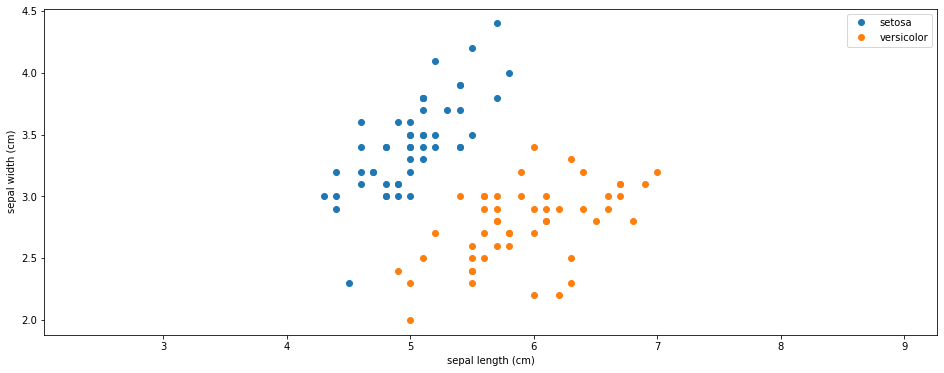

In [5]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))
for target, target_name in enumerate(names[0:2]):
    X_plot = X[y == target]
    ax1.plot(X_plot[:, 1], X_plot[:, 2], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();

$$\DeclareMathOperator*{\argmin}{arg\,min}$$
$$\def\E{{\mathbb{E}}}$$
$$\def\rvu{{\mathbf{u}}}$$
$$\def\rvTheta{{\bm{\Theta}}}$$
$$\def\gU{{\mathcal{U}}}$$
$$\def\mX{{\mathbf{X}}}$$

## Controlled Schrodinger Follmer Sampler

The objevtive we are trying to implement is:

\begin{align}
  \mathbf{u}_t^{*}=  \argmin_{\rvu_t \in \mathcal{U}}\mathbb{E}\left[\frac{1}{2\gamma}\int_0^1||\rvu(t, \Theta_t)||^2 dt - \ln\left(\frac{ p(\mX | \Theta_1)p(\Theta_1)}{\mathcal{N}(\Theta_1|\mathbf{0}, \gamma \mathbb{I} )}\right)\right] \
\end{align}

Where:
\begin{align}
d\Theta_t = \rvu(t, \Theta_t)dt + \sqrt{\gamma} dB_t
\end{align}

To do so we use the EM discretisation. However results are a bit strange. The weights sampled at $\Theta_1^{\mathbf{u}^*}$ are too large (despite the perfect predictive accuracy). So something is off. Its as though the girsanov factor is failing to regularize the model. This needs more investigation.

### Note on the bug

I have a MAP baseline implemented further down. It seems to be the case that the map baseline is also converging to similar large values as the CSF sampler so whatever the bug is its in both places. 

### Maybe there is no bug

I just tweakted $p(\theta)$ to be much more confident and now the weights are much smaller which is expected behaviour and we see the same behaviour in MAP. So maybe there is no bug , I still find that when $\sigma_w=1$ the prior is having less effect than I would expect so stil not completely sure we are bug free. 

In [6]:
def gaussian_prior(Θ, σ_w=1.0):
    """
    Logistic regresion bayesian prior
    """
    return -0.5 * (Θ**2).sum(axis=1) / σ_w


def log_likelihood(Θ, X, y):
    """
    Slow implementation of logistic log likleihood
    as a function of the parameters
    """
    logits = X.mm(Θ.T)
    
    vector_loss = - (torch.einsum("a,ab->b", y, torch.nn.functional.logsigmoid(logits)) +
                     torch.einsum("a,ab->b", (1-y), torch.log(1-torch.sigmoid(logits)))
                    )
    return vector_loss


def log_likelihood_vmap(Θ, X, y):
    """
    Hoping this implementation is less buggy / faster
    
    still feels a bit slow.
    """
    logits = X.mm(Θ.T)
    
    pos_weights = torch.ones(logits.shape[0], device=device)
         
    loss = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights, reduction="sum")
    
    # TODO: Double check this is right, changed to a minus sign here
    loss_ = lambda x: -1.0 * loss(x, y)
    
    batched_loss =  torch._vmap_internals.vmap(loss_)

    return batched_loss(logits.T)

In [7]:
Δt=0.05
t_size = int(math.ceil(1.0/Δt))
dim = 3

ts = torch.linspace(0, 1, t_size).to(device)
no_posterior_samples = 50

sde = FollmerSDE(dim, dim, no_posterior_samples, 1.0, device=device).to(device)
Θ_0 = torch.zeros((no_posterior_samples, dim)).to(device) # Θ_0 ~ δ_0

# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
ys = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)

In [8]:
stl_relative_entropy_control_cost(sde, Θ_0, X_train, y_train, 
                                  gaussian_prior, log_likelihood_vmap, γ=1.0, device=device)

C:\Users\vargf\AppData\Local\Temp/ipykernel_45612/381526447.py:36: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  batched_loss =  torch._vmap_internals.vmap(loss_)


tensor(68.9667, device='cuda:0', grad_fn=<MeanBackward0>)

In [10]:
γ = 1.0
Δt=0.05
t_size = int(math.ceil(1.0/Δt))
print(t_size)
ts = torch.linspace(0, 1, t_size).to(device)

sde = FollmerSDE(dim, dim, no_posterior_samples  , γ=γ, device=device).to(device)
optimizer = torch.optim.Adam(sde.μ.parameters(), lr=0.01, weight_decay =1)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)
losses = []
num_steps = 300
loss_ = stl_relative_entropy_control_cost if stl else relative_entropy_control_cost
for i in tqdm(range(num_steps)):
    optimizer.zero_grad()

    if isinstance(optimizer, torch.optim.LBFGS):
        def closure():
            loss = loss_(
                sde, Θ_0.float(),
                X_train.float(), y_train.float(),
                gaussian_prior, log_likelihood_vmap, γ=γ, device=device
            )
            optimizer.zero_grad()
            loss.backward()
            return loss

        optimizer.step(closure)
        losses.append(closure().item())
    else:
        loss = loss_(
            sde, Θ_0,
            X_train, y_train,
            gaussian_prior, log_likelihood_vmap, γ=γ, device=device
        )
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        losses.append(loss.item())
    if stl:
        sde.μ_detached.load_state_dict((sde.μ.state_dict()))

20


  0%|          | 0/300 [00:00<?, ?it/s]

C:\Users\vargf\AppData\Local\Temp/ipykernel_45612/381526447.py:36: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  batched_loss =  torch._vmap_internals.vmap(loss_)


In [11]:
losses

[62.20198440551758,
 65.46458435058594,
 58.84147262573242,
 50.68989944458008,
 54.94697952270508,
 53.68611145019531,
 54.35379409790039,
 49.2503662109375,
 39.19563293457031,
 40.52800750732422,
 33.57822799682617,
 34.376285552978516,
 20.973169326782227,
 18.368730545043945,
 17.05548095703125,
 17.798377990722656,
 21.597713470458984,
 21.10769271850586,
 19.8099308013916,
 18.025537490844727,
 16.549161911010742,
 17.363203048706055,
 16.128873825073242,
 15.896316528320312,
 16.694047927856445,
 16.543170928955078,
 15.951041221618652,
 17.26776885986328,
 15.094223022460938,
 15.110580444335938,
 15.37502384185791,
 16.357458114624023,
 16.7097110748291,
 16.164934158325195,
 14.981342315673828,
 15.164848327636719,
 15.177905082702637,
 16.34048080444336,
 16.72007179260254,
 15.917129516601562,
 16.75259017944336,
 15.314960479736328,
 16.87232780456543,
 16.13477897644043,
 15.93175983428955,
 17.187021255493164,
 14.002197265625,
 15.70395565032959,
 15.040109634399414,
 

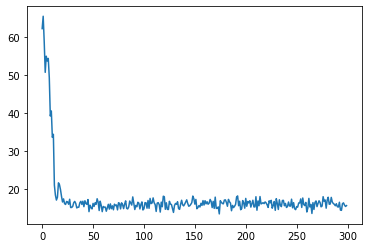

In [12]:
plt.plot(losses[:])

In [13]:
 torchsde.sdeint(sde, Θ_0, ts, method="euler", dt=Δt).shape

torch.Size([20, 50, 3])

In [14]:
X_train.shape

torch.Size([80, 3])

In [15]:
Θ_1 = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)[-1,...]

(array([ 5.,  1.,  5., 11.,  6.,  6.,  6.,  7.,  2.,  1.]),
 array([-4.7789087, -4.3267236, -3.8745384, -3.422353 , -2.9701679,
        -2.5179827, -2.0657976, -1.6136123, -1.1614271, -0.7092419,
        -0.2570567], dtype=float32),
 <a list of 10 Patch objects>)

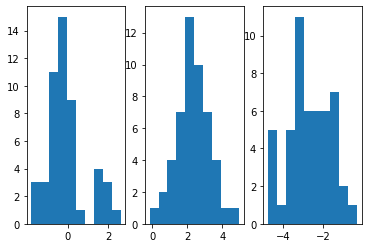

In [16]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

ax1.hist(Θ_1[:,0].cpu().detach().numpy())
ax2.hist(Θ_1[:,1].cpu().detach().numpy())
ax3.hist(Θ_1[:,2].cpu().detach().numpy())

In [17]:
pred = torch.sigmoid(X_train.mm(Θ_1.T)).mean(axis=1)

In [18]:
((pred > 0.5).float() == y_train).float().mean()

tensor(0.9875, device='cuda:0')

In [19]:
pred_test = torch.sigmoid(X_test.float().mm(Θ_1.T)).mean(axis=1)

In [20]:
((pred_test > 0.5).float() == y_test).float().mean()

tensor(1., device='cuda:0')

In [21]:
Θ_1.mean(axis=0)

tensor([-0.0330,  2.3535, -2.6469], device='cuda:0', grad_fn=<MeanBackward1>)

In [22]:
y_test, (pred_test < 0.5).long()

(tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
         1., 1.], device='cuda:0'),
 tensor([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
        device='cuda:0'))

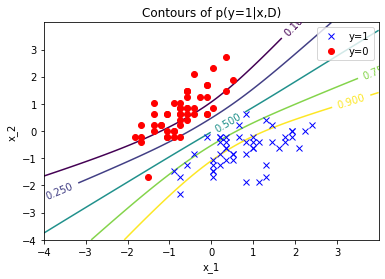

In [23]:
plt.clf()

scaler = StandardScaler()
X_scaled2 = scaler.fit_transform(X)

plt.plot(X_scaled2[y==1, 1], X_scaled2[y==1, 2], 'bx')
plt.plot(X_scaled2[y==0, 1], X_scaled2[y==0, 2], 'ro')
plt.legend(('y=1', 'y=0'))


# # Overlay contour plot of approximate predictive distribution:
x_grid = np.arange(-4, 4, 0.005)
X1, X2 = np.meshgrid(x_grid, x_grid)
NG = X1.size
X_test_2 = np.hstack((np.ones((NG,1)), X1.reshape(NG,1), X2.reshape(NG,1)))
X_test_2.shape

X_test_2_tt = torch.tensor(X_test_2).to(device).float()
p_test  = torch.sigmoid(X_test_2_tt.cpu().mm(Θ_1.cpu().T)).mean(axis=1).detach().cpu().numpy()

# kappa = 1.0 / np.sqrt(1 + (np.pi/8)*np.sum(np.dot(X_test,V)*X_test, 1))
# p_test = 1.0 / (1+np.exp(-np.dot(X_test,mm)*kappa))
P = np.reshape(p_test, X1.shape)
CS = plt.contour(X1, X2, P, [0.1,0.25,0.5,0.75,0.9])
plt.clabel(CS)
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.title('Contours of p(y=1|x,D)')
plt.show()

## MAP Baseline

We run the point estimate approximation (Maximum a posteriori) to double check what the learned weights look like.  We get the  exact same training accuracy as with the controlled model and similarly large weights for the non bias weights. 

In [14]:
X.shape

(100, 3)

In [10]:
Θ_map = torch.zeros((1, dim), requires_grad=True, device=device)
optimizer_map = torch.optim.Adam([Θ_map], lr=0.05)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)

losses_map = []
num_steps = 1000
for i in tqdm(range(num_steps)):
    optimizer_map.zero_grad()

    if isinstance(optimizer_map, torch.optim.LBFGS):
        def closure_map():
            loss_map = log_likelihood_vmap()
            optimizer_map.zero_grad()
            loss_map.backward()
            return loss

        optimizer_map.step(closure_map)
        losses_map.append(closure_map().item())
    else:
        loss_map = -(log_likelihood_vmap(Θ_map, X_train, y_train) + gaussian_prior(Θ_map))
        optimizer_map.zero_grad()
        loss_map.backward()
        print(loss_map.item())
        optimizer_map.step()
        losses_map.append(loss_map.item())

Θ_map
pred_map = torch.sigmoid(X_train.mm(Θ_map.T)).mean(axis=1)
((pred_map < 0.5).float() == y_train).float().mean(), Θ_map

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\vargf\AppData\Local\Temp/ipykernel_2136/381526447.py:36: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  batched_loss =  torch._vmap_internals.vmap(loss_)


55.45177459716797
52.67886734008789
50.03776931762695
47.52959442138672
45.154483795166016
42.91158676147461
40.79913330078125
38.81449508666992
36.95428466796875
35.21445083618164
33.590423583984375
32.07719421386719
30.66946029663086
29.36173439025879
28.148420333862305
27.023902893066406
25.982643127441406
25.019207000732422
24.128328323364258
23.30495262145996
22.54424476623535
21.841611862182617
21.192726135253906
20.593515396118164
20.040164947509766
19.529117584228516
19.057064056396484
18.620927810668945
18.21786880493164
17.845247268676758
17.500642776489258
17.181812286376953
16.886699676513672
16.613401412963867
16.360179901123047
16.12543487548828
15.907696723937988
15.705615997314453
15.517951011657715
15.343571662902832
15.181438446044922
15.030595779418945
14.890161514282227
14.759340286254883
14.637393951416016
14.523643493652344
14.417470932006836
14.318305969238281
14.225625991821289
14.13895034790039
14.057838439941406
13.981886863708496
13.910720825195312
13.8439960

12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634

(tensor(0., device='cuda:0'),
 tensor([[ 0.0000,  2.4463, -2.1438]], device='cuda:0', requires_grad=True))

## Pyro Bayesian Logistic Regeression

As a baseline we run pyro with SVI on this same example atm we get very different results which is a bit worrying.

#### EDIT:

I think results are actually in agreement what was happening is the priors in the pyro code where much more confident thus the smaller weights. I just tried changing the prior of this pyro model and the posterior is not changing much, this is a bit fishy maybe worth investigating. 

I think it might just be the case that this model is not very good.

In [23]:
import numpy as np
import scipy.special as ssp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.distributions.constraints as constraints

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import pyro
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD

pyro.enable_validation(True)
torch.set_default_dtype(torch.double) # this was necessary on the CPU

In [24]:

# these were adapted from the Pyro VAE tutorial

def train(svi, train_loader, n_train):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for _, xs in enumerate(train_loader):
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(*xs)

    # return epoch loss
    total_epoch_loss_train = epoch_loss / n_train
    return total_epoch_loss_train


def evaluate(svi, test_loader, n_test):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for _, xs in enumerate(test_loader):
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(*xs)

    total_epoch_loss_test = test_loss / n_test
    return total_epoch_loss_test


def plot_llk(train_elbo, test_elbo, test_int):
    plt.figure(figsize=(8, 6))

    x = np.arange(len(train_elbo))

    plt.plot(x, train_elbo, marker='o', label='Train ELBO')
    plt.plot(x[::test_int], test_elbo, marker='o', label='Test ELBO')
    plt.xlabel('Training Epoch')
    plt.legend()
    plt.show()

In [25]:
class LogRegressionModel(nn.Module):
    def __init__(self, p):
        super(LogRegressionModel, self).__init__()
        
        self.p = p

        # hyperparameters for normal priors
        self.alpha_h_loc = torch.zeros(1, p)
        self.alpha_h_scale = 0.0001 * torch.ones(1, p)
        self.beta_h_loc = torch.zeros(1)
        self.beta_h_scale =  0.0001 * torch.ones(1)
        
        # initial values of variational parameters
        self.alpha_0 = np.zeros((1, p))
        self.alpha_0_scale = np.ones((1, p))
        self.beta_0 = np.zeros((1,))
        self.beta_0_scale = np.ones((1,))

    def model(self, x, y):
        # sample from prior
        a = pyro.sample(
            "weight", dist.Normal(self.alpha_h_loc, self.alpha_h_scale, validate_args=True).independent(1)
        ).float()
        b = pyro.sample(
            "bias", dist.Normal(self.beta_h_loc, self.beta_h_scale, validate_args=True).independent(1)
        ).float()

        with pyro.iarange("data", x.size(0)):
#             import pdb; pdb.set_trace()
            model_logits = (torch.matmul(x, a.permute(1, 0)) + b).squeeze()
            
            pyro.sample(
                "obs", 
                dist.Bernoulli(logits=model_logits, validate_args=True),
                obs=y.squeeze()
            )
            
    def guide(self, x, y):
        # register variational parameters with pyro
        alpha_loc = pyro.param("alpha_loc", torch.tensor(self.alpha_0))
        alpha_scale = pyro.param("alpha_scale", torch.tensor(self.alpha_0_scale),
                                 constraint=constraints.positive)
        beta_loc = pyro.param("beta_loc", torch.tensor(self.beta_0))
        beta_scale = pyro.param("beta_scale", torch.tensor(self.beta_0_scale),
                                constraint=constraints.positive)

        pyro.sample(
            "weight", dist.Normal(alpha_loc, alpha_scale, validate_args=True).independent(1)
        )
        pyro.sample(
            "bias", dist.Normal(beta_loc, beta_scale, validate_args=True).independent(1)
        )
    
    
    def guide_(self, x, y, N=100):
        # register variational parameters with pyro
        alpha_loc = pyro.param("alpha_loc", torch.tensor(self.alpha_0))
        alpha_scale = pyro.param("alpha_scale", torch.tensor(self.alpha_0_scale),
                                 constraint=constraints.positive)
        beta_loc = pyro.param("beta_loc", torch.tensor(self.beta_0))
        beta_scale = pyro.param("beta_scale", torch.tensor(self.beta_0_scale),
                                constraint=constraints.positive)
        w = []
        b = []
        for _ in range(N):
            w.append(torch.tensor(pyro.sample(
                "weight", dist.Normal(alpha_loc, alpha_scale, validate_args=True).independent(1)
            )))
            b.append(torch.tensor(pyro.sample(
                "bias", dist.Normal(beta_loc, beta_scale, validate_args=True).independent(1)
            )))
#         import pdb;pdb.set_trace()
        return torch.vstack(w), torch.vstack(b)

In [26]:

pyro.clear_param_store()

optim = Adam({'lr': 0.01})

num_epochs = 1000
batch_size = 50

N = X.shape[0]
p = 2

n_train = X_train.shape[0]
example_indices = np.random.permutation(N)
n_test = N - n_train
test_iter = 50

In [27]:
lr_model = LogRegressionModel(p=p)

svi = SVI(
    lr_model.model, lr_model.guide, optim,
    loss=Trace_ELBO()
)


lr_dataset = torch.utils.data.TensorDataset(torch.tensor(X[:,1:]).float(), torch.tensor(y.reshape(-1,1)).float())

data_loader_train = DataLoader(
    dataset=lr_dataset, batch_size=batch_size, pin_memory=False,
    sampler=SubsetRandomSampler(example_indices[:n_train]),
)
    
data_loader_test = DataLoader(
    dataset=lr_dataset, batch_size=batch_size, pin_memory=False,
    sampler=SubsetRandomSampler(example_indices[n_train:]),
)

train_elbo = []
test_elbo = []
for epoch in range(num_epochs):
    total_epoch_loss_train = train(svi, data_loader_train, n_train)
    train_elbo.append(-total_epoch_loss_train)

    if epoch % test_iter == 0:
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, data_loader_test, n_test)
        test_elbo.append(-total_epoch_loss_test)

[epoch 000]  average training loss: 1220005.2042
[epoch 050]  average training loss: 316690.8360
[epoch 100]  average training loss: 578170.2876
[epoch 150]  average training loss: 568008.1648
[epoch 200]  average training loss: 307361.8592
[epoch 250]  average training loss: 131007.7829
[epoch 300]  average training loss: 73617.5958
[epoch 350]  average training loss: 191313.3133
[epoch 400]  average training loss: 111897.0367
[epoch 450]  average training loss: 300512.3689
[epoch 500]  average training loss: 19642.3765
[epoch 550]  average training loss: 59578.3530
[epoch 600]  average training loss: 97903.6400
[epoch 650]  average training loss: 55632.0432
[epoch 700]  average training loss: 116581.4045
[epoch 750]  average training loss: 31808.7584
[epoch 800]  average training loss: 91703.4840
[epoch 850]  average training loss: 20083.9464
[epoch 900]  average training loss: 16839.9660
[epoch 950]  average training loss: 48150.2470


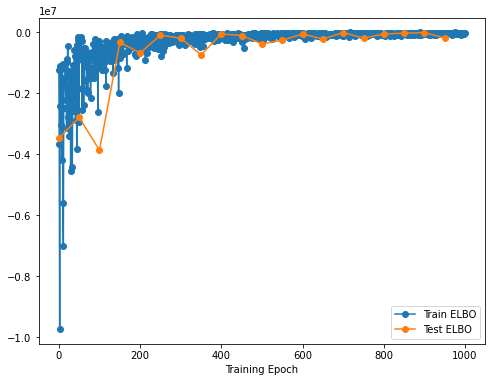

In [28]:
plot_llk(train_elbo, test_elbo, test_iter)

In [29]:
W, b = lr_model.guide_(X_train.float(), y_train.float())

C:\Users\vargf\AppData\Local\Temp/ipykernel_17988/447687565.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w.append(torch.tensor(pyro.sample(
C:\Users\vargf\AppData\Local\Temp/ipykernel_17988/447687565.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b.append(torch.tensor(pyro.sample(


(array([ 3.,  6.,  8., 14., 19., 20., 11., 15.,  3.,  1.]),
 array([-0.1924847 , -0.14957977, -0.10667484, -0.06376991, -0.02086498,
         0.02203994,  0.06494487,  0.1078498 ,  0.15075473,  0.19365966,
         0.23656459]),
 <a list of 10 Patch objects>)

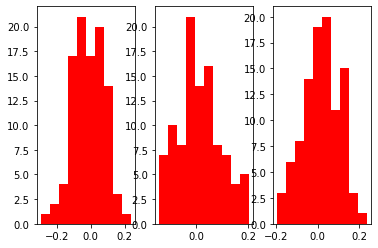

In [30]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

# ax1.hist(Θ_1[:,0].detach().numpy())
# ax2.hist(Θ_1[:,1].detach().numpy())
# ax3.hist(Θ_1[:,2].detach().numpy())


ax1.hist(b.detach().numpy(), color="red")
ax2.hist(W[:,0].detach().numpy(), color="red")
ax3.hist(W[:,1].detach().numpy(), color="red")


In [31]:
b.mean(), W.mean(axis=0)

(tensor(-0.0138), tensor([0.0121, 0.0196]))